In [1]:
import numpy as np
import pandas
import matplotlib.pyplot as plt
import scipy.stats
import sklearn.linear_model

# 8.1 Confidence intervals / parametric resampling

### Example: confidence interval for mle

Dataset: $x=(x_1,\dots,x_n)$

Model: $X_i\sim N(\mu,\sigma^2)$, where $\mu$ and $\sigma$ are unknown.
The maximum likelihood estimators are
$$
\hat{\mu}=\bar{x}=\frac{1}{n}\sum_{i=1}^n x_i,\qquad
\hat{\sigma}=\sqrt{\frac{1}{n}\sum_{i=1}^n (x_i-\hat{\mu})^2}
$$

Want a 95% interval for $\hat{\mu}$.

95% confint [7.47,8.77]


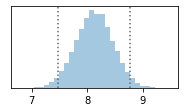

In [2]:
x = [7.2, 7.3, 7.8, 8.2, 8.8, 9.5]
n = len(x)
 
# 1. Define the readout statistic
def μhat(x): return np.mean(x)

# 2. To generate a synthetic dataset ...
σhat = np.sqrt(np.mean((x-μhat(x))**2))
def rx(): return np.random.normal(loc=μhat(x), scale=σhat, size=n)

# 3. Sample the readout statistic, and report its spread
μhat_ = [μhat(rx()) for _ in range(10000)]
lo,hi = np.quantile(μhat_, [.025, .975])
print(f"95% confint [{lo:.3},{hi:.3}]")

fig,ax = plt.subplots(figsize=(3,1.5))
ax.hist(μhat_, bins=30, alpha=.4)
ax.axvline(lo, linestyle='dotted', color='0.4')
ax.axvline(hi, linestyle='dotted', color='0.4')
ax.set_yticks([])
plt.show()

### Example: comparing groups

Dataset: $x=(x_1,\dots,x_m)$, $y=(y_1,\dots,y_n)$

Model: $X_i\sim N(\mu,\sigma^2)$, $Y_i\sim N(\nu,\sigma^2)$. The maximum likelihood estimators are
$$
\mu=\bar{x},\qquad
\nu=\bar{y},\qquad
\hat{\sigma}=\sqrt{\frac{1}{m+n}\left\{\sum(x_i-\hat{\mu})^2+\sum(y_i-\hat{\nu})^2\right\}}
$$

Want a 95% confidence interval for the difference between the two group means, $\hat{\nu}-\hat{\mu}$

95% confint [-0.448,3.74]


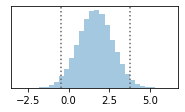

In [6]:
x = [4.3, 5.1, 6.1, 6.8, 7.4, 8.8, 9.9]
y = [8.3, 8.5, 8.9]
m,n = len(x), len(y)

# 1. Define a readout statistic
def t(x,y): return np.mean(y) - np.mean(x)

# 2. To generate a synthetic dataset ...
# Note that we should generate a dataset of the same shape as the observed data,
# i.e. a list of x-values and a list of y-values.
μhat,νhat = np.mean(x), np.mean(y)
σhat = np.sqrt((np.sum((x-μhat)**2) + np.sum((y-νhat)**2))/(m+n))
def rxy():
    return (np.random.normal(loc=μhat, scale=σhat, size=m), 
            np.random.normal(loc=νhat, scale=σhat, size=n))

# 3. Sample the readout statistic, and reports its spread
t_ = [t(*rxy()) for _ in range(50000)]
lo,hi = np.quantile(t_, [.025, .975])
print(f"95% confint [{lo:.3},{hi:.3}]")

fig,ax = plt.subplots(figsize=(3,1.5))
ax.hist(t_, bins=30, alpha=.4)
ax.axvline(lo, linestyle='dotted', color='0.4')
ax.axvline(hi, linestyle='dotted', color='0.4')
ax.set_yticks([])
plt.show()

### Example: fires in the Amazon

See [The Guardian article](https://www.theguardian.com/world/2019/aug/30/corporations-pile-pressure-on-brazil-over-amazon-fires-crisis).

Dataset: $x_i$ is the cumulative number of fires in year $i$, $i\in\{2011,\dots,2019\}$, from the start of the year up to day 240 (29 August).

Model: $X_{2011},\dots,X_{2018}\sim N(\mu,\sigma^2)$ and $X_{2019}\sim N(\mu+\delta,\sigma^2)$

Want a 95% confidence interval for $\hat{\delta}$

It's easy to write down formulae for $\hat{\mu}$, $\hat{\delta}$, and $\hat{\sigma}$. Instead, this code snippet uses a slower brute force method, which is useful to know for more complex models where the formulae aren't easy. We'll  use a library routine to fit a linear model, and extract its coefficients:
$$
\textbf{x} \sim \mu\textbf{1} + \delta 1_{\textbf{year}=2019} + N(0,\sigma^2)
$$

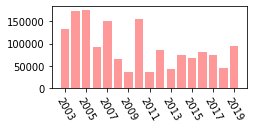

In [7]:
modis = pandas.read_csv('https://www.cl.cam.ac.uk/teaching/2122/DataSci/data/modis.csv')
modis = modis.loc[modis.day_of_year==240].sort_values('year')
modis = modis.sort_values('year')

fig,ax = plt.subplots(figsize=(3.5,1.5))
ax.bar(modis.year, modis.num_fires, width=0.8, alpha=.4, color='red')
plt.xticks(np.arange(2003,2020,2), rotation=-60)
plt.show()

In [8]:
# restrict attention to the years 2011--2019
i = (modis.year >= 2011) & (modis.year <= 2019)
year,fires = modis.year.loc[i].values, modis.num_fires.loc[i].values

95% confint [-2550,66408]


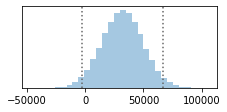

In [14]:
# The feature vectors to use for the linear models
X = np.column_stack([year==2019])

# 1. Define the readout statistic
# Report the δ coefficient from a fitted linear model on the response vector x
def δhat(x): 
    m = sklearn.linear_model.LinearRegression()
    m.fit(X, x)
    (δ,) = m.coef_
    return δ

# 2. To generate a synthetic dataset ...
# we simply sample new values from the fitted model
m = sklearn.linear_model.LinearRegression()
m.fit(X, fires)
pred = m.predict(X)
σhat = np.sqrt(np.mean((fires-pred)**2))
def rx(): return np.random.normal(loc=pred, scale=σhat)

# 3. Sample the readout statistic and report its spread
δhat_ = np.array([δhat(rx()) for _ in range(50000)])
lo,hi = np.quantile(δhat_, [.025, .975])
print(f"95% confint [{lo:.0f},{hi:.0f}]")

fig,ax = plt.subplots(figsize=(3.5,1.5))
ax.hist(δhat_, bins=30, alpha=.4)
ax.axvline(lo, linestyle='dotted', color='0.4')
ax.axvline(hi, linestyle='dotted', color='0.4')
ax.set_yticks([])
plt.show()

# 8.2 Hypothesis tests / parametric resampling

### Example: comparing two groups

Dataset: $x=(x_1,\dots,x_m)$, $y=(y_1,\dots,y_n)$

General model: $X_i\sim N(\mu,\sigma^2)$, $Y_i\sim N(\mu+\delta,\sigma^2)$. Under this general model, the maximum likelihood estimator for $\delta$ is $\hat{\delta}=\bar{y}-\bar{x}$. We'll use this as our test statistic.

Null hypothesis: $\delta=0$. If this is true, then all the $X_i$ and $Y_i$ are $\sim N(\mu,\sigma^2)$.

p=0.163


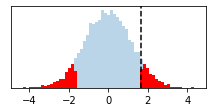

In [15]:
x = [4.3, 5.1, 6.1, 6.8, 7.4, 8.8, 9.9]
y = [8.3, 8.5, 8.9]

# 1. Define the test statistic
def t(x,y): return np.mean(y) - np.mean(x)

# 2. To generate a synthetic dataset ...
μhat = np.mean(np.concatenate([x,y]))
σhat = np.sqrt(np.mean((np.concatenate([x,y])-μhat)**2))
def rxy(): 
    return (np.random.normal(loc=μhat, scale=σhat, size=len(x)),
            np.random.normal(loc=μhat, scale=σhat, size=len(y)))

# 3. Sample the test statistic, compare to what was observed
# If H0 weren't true, i.e. if δ!=0, then t might go bigger or it might go smaller,
# so large t on either side is evidence against H0,
# so we want a two-sided p-value.
t_ = np.array([t(*rxy()) for _ in range(10000)])
p = 2 * min(np.mean(t_ >= t(x,y)), np.mean(t_ <= t(x,y)))
print(f"p={p:.3}")

fig,ax = plt.subplots(figsize=(3.5,1.5))
bins = np.linspace(-4.5, 4.5, 60)
ax.hist(t_, bins=bins, alpha=.3)
ax.hist(t_[t_>=t(x,y)], bins=bins, color='red')
ax.hist(t_[t_<=np.quantile(t_,p/2)], bins=bins, color='red')
ax.axvline(x=t(x,y), linestyle='dashed', color='black')
ax.set_yticks([])
plt.show()

### Example: comparing several groups

Dataset: three lists of values, $x$, $y$, and $z$

General model: $X_i\sim N(\mu_x,\sigma^2)$, $Y_i\sim N(\mu_y,\sigma^2)$, $Z_i\sim N(\mu_z,\sigma^2)$.

Null hypothesis: $\mu_x=\mu_y=\mu_z$.

Test statistic: $t=(\hat{\mu}_x-\hat{\mu})^2+(\hat{\mu}_y-\hat{\mu})^2+(\hat{\mu}_z-\hat{\mu})^2$. If $H_0$ is false, we'd expect $t$ to be large (bigger +ve).

p=0.595


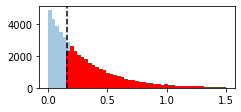

In [17]:
x = [7.2, 7.3, 7.8, 8.2, 8.8, 9.5]
y = [8.3, 8.5, 9.2]
z = [7.4, 8.5, 9.0]

# 1. Define test statistic
def t(x,y,z):
    m = np.mean(np.concatenate([x,y,z]))
    a,b,c = [np.mean(v) for v in [x,y,z]]
    return (a-m)**2 + (b-m)**2 + (c-m)**2

# 2. To generate a synthetic dataset, assuming H0 ...
xyz = np.concatenate([x,y,z])
μhat = np.mean(xyz)
σhat = np.sqrt(np.mean((xyz-μhat)**2))
def rxyz():
    return (np.random.normal(size=len(x), loc=μhat, scale=σhat),
            np.random.normal(size=len(y), loc=μhat, scale=σhat),
            np.random.normal(size=len(z), loc=μhat, scale=σhat))

# 3. Sample the test statistic, find the p-value
t_ = np.array([t(*rxyz()) for _ in range(50000)])
p = np.mean(t_ >= t(x,y,z))
print(f"p={p:.3}")

fig,ax = plt.subplots(figsize=(3.5,1.5))
bins = np.linspace(0, 1.5, 50)
ax.hist(t_, bins=bins, alpha=.4)
ax.hist(t_[t_>=t(x,y,z)], bins=bins, color='red')
ax.axvline(t(x,y,z), linestyle='dashed', color='black')
plt.show()

### Example: fires in the Amazon

Dataset: $x_i$ is the cumulative number of fires in year $i$, $i\in\{2011,\dots,2019\}$, from the start of the year up to day 240 (29 August).

Null hypothesis model: $X_i\sim N(\mu,\sigma^2)$

Test statistic: $x_{2019}/x_{2018}$. We'll consider big (large +ve) values of the test statistic to be evidence against $H_0$.

In [18]:
modis = pandas.read_csv('https://www.cl.cam.ac.uk/teaching/2122/DataSci/data/modis.csv')
modis = modis.loc[modis.day_of_year==240].sort_values('year')
modis = modis.sort_values('year')
# restrict attention to the years 2011--2019
fires = modis.num_fires.loc[(modis.year>=2011) & (modis.year<=2019)].values

p=0.053


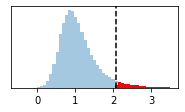

In [19]:
# 1. Define the test statistic
def t(x): return x[-1]/x[-2]

# 2. To generate a synthetic dataset, assuming H0 ...
μhat = np.mean(fires)
σhat = np.sqrt(np.mean((fires-μhat)**2))
def rx(): return np.random.normal(size=len(fires), loc=μhat, scale=σhat)

# 3. Sample the test statistic, compare to observed value, find the p-value
t_ = np.array([t(rx()) for _ in range(100000)])
p = np.mean(t_ >= t(fires))
print(f"p={p:.2}")

fig,ax = plt.subplots(figsize=(3,1.5))
bins = np.linspace(-.5, 3.5, 50)
ax.hist(t_, bins=bins, alpha=.4)
ax.hist(t_[t_>=t(fires)], bins=bins, color='red')
ax.axvline(t(fires), linestyle='dashed', color='black')
ax.set_yticks([])
plt.show()

# 8.3 Non-parametric resampling

### Example: confidence interval for comparing groups

Dataset: $x=(x_1,\dots,x_m)$, $y=(y_1,\dots,y_n)$

We want a 95% confidence interval for $\bar{y}-\bar{x}$.

95% confint [0.238,3.0]


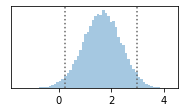

In [22]:
x = [4.3, 5.1, 6.1, 6.8, 7.4, 8.8, 9.9]
y = [8.3, 8.5, 8.9]

# 1. Define a readout statistic
def t(x,y): return np.mean(y) - np.mean(x)

# 2. To generate a synthetic dataset ...
# Here we're sampling from the empirical distributions
# (which are the best possible fitted distributions)
# As usual, we have to return a synthetic dataset of
# the same shape as the dataset we're given.
def rxy(): 
    return (np.random.choice(x, size=len(x)),
            np.random.choice(y, size=len(y)))

# 3. Sample the readout statistic, and report its spread
t_ = [t(*rxy()) for _ in range(100000)]
lo,hi = np.quantile(t_, [.025, .975])
print(f"95% confint [{lo:.3},{hi:.3}]")

fig,ax = plt.subplots(figsize=(3,1.5))
ax.hist(t_, bins=60, alpha=.4)
ax.axvline(lo, linestyle='dotted', color='0.4')
ax.axvline(hi, linestyle='dotted', color='0.4')
ax.set_yticks([])
plt.show()

### Example: testing if two groups come from the same distribution

Dataset: $x=(x_1,\dots,x_m)$, $y=(y_1,\dots,y_n)$

Null hypothesis: the two groups of readings come from the same distribution.
If this is so, then the best possible fit for their common distribution is
the empirical distribution of $(x_1,\dots,x_m,y_1,\dots,y_n)$.

Test statistic: let's use $\bar{y}-\bar{x}$. If they come from the same distribution, this should be close to 0. If they come from different distributions (or, more precisely, if they come from distributions with different means), this might go more +ve or it might go more -ve, depending on the difference in means.

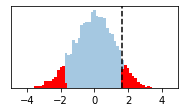

In [23]:
x = [4.3, 5.1, 6.1, 6.8, 7.4, 8.8, 9.9]
y = [8.3, 8.5, 8.9]

# 1. Define the test statistic
def t(x,y): return np.mean(y) - np.mean(x)

# 2. To generate a synthetic dataset, assuming H0 ...
# As usual, we want to return a synthetic dataset of the same shape as the observed dataset
def rxy():
    return (np.random.choice(np.concatenate([x,y]), size=len(x)),
            np.random.choice(np.concatenate([x,y]), size=len(y)))

# 3. Sample the test statistic, compare to observed value, find the p-value
# In this case, "extreme" means "large +ve or large -ve", so we want a two-sided p-value
t_ = np.array([t(*rxy()) for _ in range(10000)])
p = 2 * min(np.mean(t_>=t(x,y)), np.mean(t_<=t(x,y)))

fig,ax = plt.subplots(figsize=(3,1.5))
bins = np.linspace(-4.5, 4.5, 60)
ax.hist(t_, bins=bins, alpha=.4)
ax.hist(t_[(t_ >= t(x,y)) | (t_ <= np.quantile(t_,p/2))], bins=bins, color='red')
ax.axvline(t(x,y), linestyle='dashed', color='black')
ax.set_yticks([])
plt.show()